### Box 6, Step 1	
Batch-process the data set into x-y-image files organized into a hypercube with z, λ, and t encoded as axis labels. To reduce the size of the resulting data set and speed up to subsequent steps, we have implemented a keyword argument allowing binning (Supplementary Code 3, Box 1). 

In [1]:
from hyperspectralTracking import * #tracking data class and dependencies

#just for style
display(HTML("<style>.container { width:80% !important; }</style>"))
plt.style.use('dark_background')

#define location and name of dataset
directoryName='D:\\Data for Protocol\\SI Code 3\\toShare\\'
logName='Log_2022-12-08_07-09AM_toShare.txt'
dataName='Keras3-Scan0-'

#create an instance of the acquisition class to run the auto-calibration routine
Scan0=acquisition(directoryName, dataName)
Scan0.autoCalibrate(logName, FOV50=693.54)

#batch-process the stack. binning can be applied to reduce the output file size and improve SNR
Scan0.batchProcessND(nBin=np.array([3, 3, 4, 2]), upLim=200, lowLim=40) #nBin=[bin_x, bin_y, bin_w, bin_z]

processing stack 1 out of 6
processing stack 2 out of 6
processing stack 3 out of 6
processing stack 4 out of 6
processing stack 5 out of 6
processing stack 6 out of 6


### Step 2	
Add all processed files to a .zip folder by specifying source directory and filename identifier (Supplementary Code 3, Box 2). You can now delete the batch-processed images from the directory.
▲ CRITICAL Ensure no additional files with the same filename identifier are in the working directory.

In [2]:
directory=Scan0.directory+'processedND\\'
file = directory+"I_total.zip"  # zip file name
with ZipFile(file, 'w') as zip:
    for path, directories, files in os.walk(directory):
        for file in files:
            file_name = os.path.join(path, file)
            if (Scan0.name+'Imap') in file_name:
                zip.write(file_name) # zipping the file

### Step 3	
Feed the .zip folder into the ND tracking algorithm TrackPY and specify input parameters.
### Step 4	
Run the tracking algorithm and export the results as excel spreadsheet (Supplementary Code 3, Box 3). The algorithm will auto-detect the centroids of objects in the x-y-z-λ-t parameter space. 

In [3]:
#load the data as ND image sequence
frames = pims.ImageSequenceND(r'D:\\Data for Protocol\\SI Code 3\\toShare\\processedND\\I_total.zip', axes_identifiers = ['z','w','t'])
frames.bundle_axes = ['w','z', 'y', 'x']
frames

<ImageSequenceND>
Source: D:\Data for Protocol\SI Code 3\toShare\processedND\I_total.zip
Axes: 5
Axis 'z' size: 19
Axis 'w' size: 150
Axis 't' size: 6
Axis 'y' size: 125
Axis 'x' size: 125
Pixel Datatype: uint8

In [4]:
#features = tp.locate(frames[0], diameter=(3, 5, 5, 3))
f = tp.batch(frames, diameter=(3, 3, 3, 3), characterize=False)

Frame 5: 60 features


In [5]:
#set some weights and spatial characteristics
weight=0.0001
f['xum'] = f['x3'] * Scan0.xStep * 3
f['yum'] = f['x2'] * Scan0.yStep * 3 
f['zum'] = f['x1'] * Scan0.zStep * 2
f['wum'] = f['x0'] * weight

#link the tracked objects and save the results
tolerance=30
linked = tp.link_df(f, tolerance, pos_columns=['xum', 'yum', 'zum', 'wum'])
linked.to_csv(Scan0.directory+Scan0.name+'NDtrack.csv')

Frame 5: 60 trajectories present.


### Step 5	
Create an instance of the trackingData class, which organizes the output from the tracking algorithm, using the name of the tracking data file as in input argument, and the acquisition object created during Step 1 (Supplementary Code 3, Box 4).

In [6]:
area=0
#read the tracking results from the organized csv file
linked=read_csv(Scan0.directory+Scan0.name+'NDtrack.csv')
databaseND=trackDataND(linked,Scan0, name='A{}_ND'.format(area))

### Step 6
Display trajectories as images or extract traces of position or wavelength of individual tracked LPs (Supplementary Code 3, Box 5).

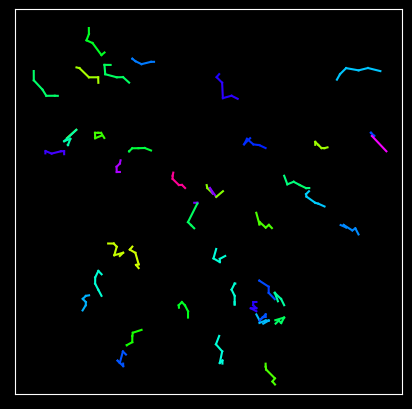

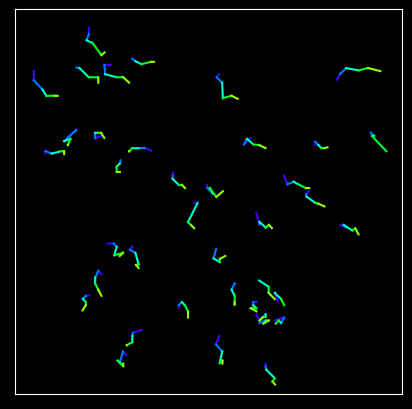

In [7]:
length=4
databaseND.plotTrajs(Scan0, minLen=length, colorCode='wL', nBin=[3,3,4,2])
databaseND.plotTrajs(Scan0, minLen=length, colorCode='time', nBin=[3,3,4,2])

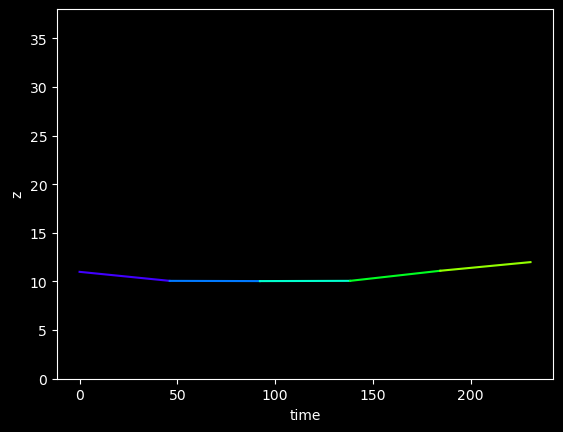

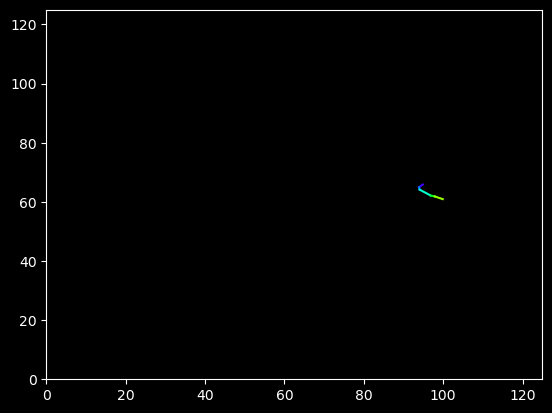

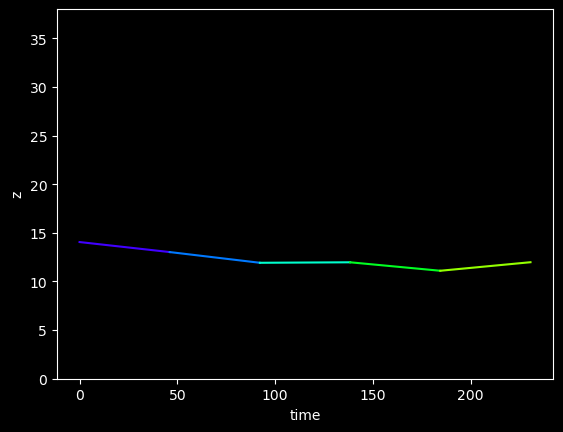

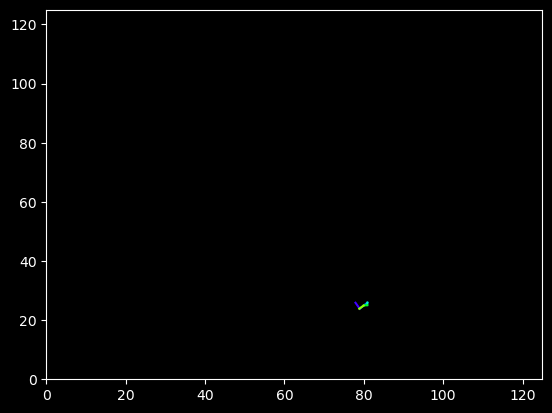

In [8]:
#example of upward migrating cell in skin layer
LPi=databaseND.disks['A0_ND2']
LPi.plotTraj(Scan0, ax0='z')
LPi.plotXY(Scan0, colorCode='time', nBin=[3,3,4,2])

#example of stationary cell in skin layer
LPi=databaseND.disks['A0_ND5']
LPi.plotTraj(Scan0, ax0='z')
LPi.plotXY(Scan0, colorCode='time', nBin=[3,3,4,2])
